In [1]:
import sys
import pandas as pd
sys.path.append("../../xapres_package/")
import xapres as xa
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs
import math

In [26]:
d = xa.load.load_zarr().isel(time=slice(300,302))


In [120]:
#def custom_profile(chirps,clip_threshold=1.2,min_chirps = 20,start=0,stop=39999,pad=2):
    # This stop of 39999 by default cuts off the last two samples
    # This function requires starting on an even number
chirps = d.chirp.isel(attenuator_setting_pair=1).load()

clip_threshold=1.2
min_chirps = 20
start=0
stop=39999
pad=2
times = chirps.chirp_time.values.astype('float64')/1e9
regular_freq_range = 2e8+2e8*times
start_freq = regular_freq_range[start]
stop_freq = regular_freq_range[stop-1]
B = stop_freq - start_freq
CentreFreq = (stop_freq + start_freq)/2
K = 2e8 # determined from step-up freq (5000 Hz) and step-up time (2.5e-5)
c0 = 3e8 # speed of light in vaccuum
ER_ICE = 3.18
T0 = times[start]
T1 = times[stop-1]

chirps

<xarray.DataArray 'chirp' (time: 2, chirp_time: 40001, chirp_num: 20)>
array([[[ 0.04875183,  0.01934052,  0.0479126 , ...,  0.0327301 ,
          0.04302979,  0.03765106],
        [ 0.04230499,  0.00839233,  0.02979279, ...,  0.0485611 ,
          0.02334595,  0.027771  ],
        [ 0.03986359, -0.02555847, -0.07919312, ...,  0.10356903,
         -0.02494812, -0.01178741],
        ...,
        [ 0.00370026,  0.00400543,  0.00648499, ...,  0.00610352,
          0.0056076 ,  0.00297546],
        [ 0.01621246,  0.01522064,  0.01647949, ...,  0.00759125,
          0.00991821,  0.00995636],
        [ 0.28560638,  0.28301239,  0.2841568 , ...,  0.27935028,
          0.28171539,  0.28160095]],

       [[ 0.00076294,  0.11383057,  0.02944946, ...,  0.03334045,
          0.01270294,  0.05149841],
        [ 0.03307343,  0.09578705,  0.05680084, ...,  0.00656128,
          0.026474  ,  0.05443573],
        [ 0.13248444,  0.03494263,  0.11417389, ..., -0.08838654,
          0.03162384,  0.02593994],
        ...,
        [ 0.00457764,  0.00385284,  0.00209808, ...,  0.01186371,
          0.01064301,  0.01064301],
        [ 0.00556946,  0.00850677,  0.00946045, ...,  0.01415253,
          0.01251221,  0.01079559],
        [ 0.27896881,  0.28079987,  0.28182983, ...,  0.28018951,
          0.27835846,  0.28003693]]])
Coordinates:
    AFGain        int64 -14
    attenuator    float64 5.0
    burst_number  (time) int64 4 5
  * chirp_num     (chirp_num) int64 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
  * chirp_time    (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename      (time) <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR20...
  * time          (time) datetime64[ns] 2022-05-29T15:06:19 2022-05-29T15:21:50
Attributes:
    description:  voltage from the analog-to-digital converter after the rece...
    long_name:    de-ramped chirp
    units:        volts

In [121]:
# Drop bad bursts
chirps = chirps.isel(chirp_time=range(start,stop))
bad_chirps =  chirps.where(abs(chirps) > clip_threshold)
good_bursts = bad_chirps.max(dim='chirp_time').count(dim='chirp_num') <= 20-min_chirps
chirps = chirps.where(good_bursts)
chirps = chirps.where(abs(chirps).max(dim='chirp_time')<clip_threshold)

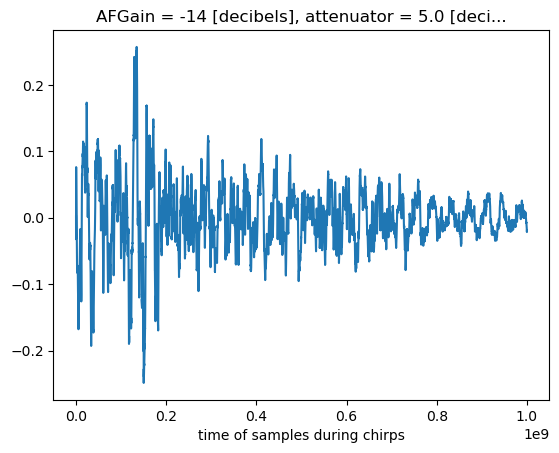

In [122]:
# De-mean and detrend
chirps = chirps - chirps.mean(dim='chirp_time')
p = chirps.polyfit('chirp_time', 1)
fit = xr.polyval(chirps.chirp_time, p.polyfit_coefficients)
chirps = chirps - fit
chirp_stack = chirps.mean(dim='chirp_num', skipna=True)

chirp_stack.isel(time=0).plot()

In [142]:
window = np.blackman(len(chirp_stack.chirp_time))
win_chirps = chirp_stack*window
win_chirps
#win_chirps.isel(time=0).plot()

<xarray.DataArray (time: 2, chirp_time: 39999)>
array([[-2.94260054e-20, -1.04601618e-11, -2.07333192e-10, ...,
        -1.90670160e-10, -4.71042907e-11,  2.72057197e-19],
       [-2.00129287e-19,  1.31131166e-11, -1.46606128e-10, ...,
        -1.78433902e-10, -4.56845577e-11,  2.83514402e-19]])
Coordinates:
    AFGain        int64 -14
    attenuator    float64 5.0
    burst_number  (time) int64 4 5
  * chirp_time    (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:00.999950
    filename      (time) <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR20...
  * time          (time) datetime64[ns] 2022-05-29T15:06:19 2022-05-29T15:21:50

In [124]:
Nt = len(chirp_stack.chirp_time)
Nt = math.floor(Nt/2) * 2
Nfft = math.floor(Nt*pad)
Nfft

79996

In [133]:
bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
profile_range = profile_range[0:math.floor(Nfft/2)-1]
# the last two lines can be replaced by 
profile_range = np.arange(0,math.floor(Nfft/2)-1) * bin2m

In [143]:
win_chirps.isel(chirp_time=slice(math.floor(Nt/2),-1))

<xarray.DataArray (time: 2, chirp_time: 19999)>
array([[-7.46950842e-03, -4.23852253e-03, -1.78573490e-03, ...,
        -4.23783640e-10, -1.90670160e-10, -4.71042907e-11],
       [-8.02440701e-03, -6.31548530e-03, -3.68531419e-03, ...,
        -3.95184587e-10, -1.78433902e-10, -4.56845577e-11]])
Coordinates:
    AFGain        int64 -14
    attenuator    float64 5.0
    burst_number  (time) int64 4 5
  * chirp_time    (chirp_time) timedelta64[ns] 00:00:00.499975 ... 00:00:00.9...
    filename      (time) <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR20...
  * time          (time) datetime64[ns] 2022-05-29T15:06:19 2022-05-29T15:21:50

In [145]:
win_chirps.data[:,math.floor(Nt/2):-1].shape

(2, 19999)

In [146]:
win_chirps.isel(chirp_time=slice(0,math.floor(Nt/2)))

<xarray.DataArray (time: 2, chirp_time: 19999)>
array([[-2.94260054e-20, -1.04601618e-11, -2.07333192e-10, ...,
        -1.28747450e-02, -1.10666420e-02, -9.87842690e-03],
       [-2.00129287e-19,  1.31131166e-11, -1.46606128e-10, ...,
        -1.20086690e-02, -1.07880293e-02, -8.68428682e-03]])
Coordinates:
    AFGain        int64 -14
    attenuator    float64 5.0
    burst_number  (time) int64 4 5
  * chirp_time    (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:00.499950
    filename      (time) <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR20...
  * time          (time) datetime64[ns] 2022-05-29T15:06:19 2022-05-29T15:21:50

In [149]:
np.all(win_chirps.data[:,0:math.floor(Nt/2)] == win_chirps.isel(chirp_time=slice(0,math.floor(Nt/2))).data)

True

In [158]:
padchirp = abs(0*win_chirps)
padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]


In [153]:
win_chirps.data[:,0:math.floor(Nt/2)].shape

(2, 19999)

In [139]:
padchirp = np.zeros((len(chirp_stack.time), Nfft))
padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
padchirp

(2, 79996)

In [169]:
middle_zeros = xr.zeros_like(chirp_stack).isel(chirp_time = slice(0,Nfft - 2*math.floor(Nt/2)))
middle_zeros

<xarray.DataArray (time: 2, chirp_time: 39998)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    AFGain        int64 -14
    attenuator    float64 5.0
    burst_number  (time) int64 4 5
  * chirp_time    (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:00.999925
    filename      (time) <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR20...
  * time          (time) datetime64[ns] 2022-05-29T15:06:19 2022-05-29T15:21:50

In [172]:
print(win_chirps.data[:,math.floor(Nt/2):-1].shape)
print(win_chirps.data[:,0:math.floor(Nt/2)].shape[1]*2+ 39998)

(2, 19999)
79996


In [159]:
win_chirps.data[:,0:math.floor(Nt/2)].shape

(2, 19999)

In [138]:
win_chirps.data[:,math.floor(Nt/2):-1].shape

(2, 19999)

### A combination of pad and roll can do this in one line (I think)

In [ ]:
# this has come form a different notebook, but it works there and gives us the right answer (/Users/jkingslake/Documents/outreach/glaciology-intro-book/src/sections/radar/apres/apres_data_1.ipynb)
t = chirp.chirp_time.values
s = s_one_chirp[:-1]
N = len(s)
s_windowed = s * np.blackman(N)
chirp_padded = np.pad(s_windowed, pad_width=int((N*pad-N)/2))
chirp_padded_rolled = np.roll(chirp_padded, shift = int(N*pad/2))


In [201]:
arr = xr.DataArray([5, 6, 7, 8], coords=[("x", [0, 1, 2, 3])])
arr.pad(x=(2, 2), constant_values=0).roll(x=4)


<xarray.DataArray (x: 8)>
array([7, 8, 0, 0, 0, 0, 5, 6])
Coordinates:
  * x        (x) float64 nan nan 0.0 1.0 2.0 3.0 nan nan

In [ ]:
p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
profile = p[:,0:math.floor(Nfft/2)-1]
m = np.asarray([i for i in range(profile.shape[1])])/pad
phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))

n = np.argmin(profile_range<=1200)
Range = profile_range[:n]
Profile = profile_ref[:,:n]



In [ ]:
p = xa.load.generate_xarray(directory = "../../data/sample/polarmetric", polarmetric=True, attended=True)

In [ ]:
p

<xarray.Dataset> Size: 205MB
Dimensions:          (orientation: 4, waypoint: 1, chirp_time: 40001,
                      chirp_num: 100, attenuator_setting_pair: 1,
                      profile_range: 11889)
Coordinates:
    time             (orientation, waypoint) datetime64[ns] 32B 2023-01-05T03...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * profile_range    (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (orientation, waypoint) <U56 896B '../../data/sample/pol...
    burst_number     (orientation, waypoint) int64 32B 0 0 0 0
    AFGain           (attenuator_setting_pair) int64 8B -4
    attenuator       (attenuator_setting_pair) float64 8B 22.0
  * orientation      (orientation) <U2 32B 'HH' 'HV' 'VH' 'VV'
  * waypoint         (waypoint) int64 8B 1
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (orientation, waypoint, chirp_time, chirp_num, attenuator_setting_pair) float64 128MB ...
    profile          (orientation, waypoint, profile_range, chirp_num, attenuator_setting_pair) complex128 76MB ...
    latitude         (orientation, waypoint) float64 32B 0.0 0.0 0.0 0.0
    longitude        (orientation, waypoint) float64 32B 0.0 0.0 0.0 0.0
    battery_voltage  (orientation, waypoint) float64 32B 0.0 0.0 0.0 0.0
    temperature_1    (orientation, waypoint) float64 32B 502.9 503.1 2.891 2.492
    temperature_2    (orientation, waypoint) float64 32B 501.6 503.6 511.8 4.93

In [ ]:
p1_stacked = p.profile.isel(orientation=0).mean(dim='chirp_num')
p2_stacked = p.profile.isel(orientation=1).mean(dim='chirp_num')

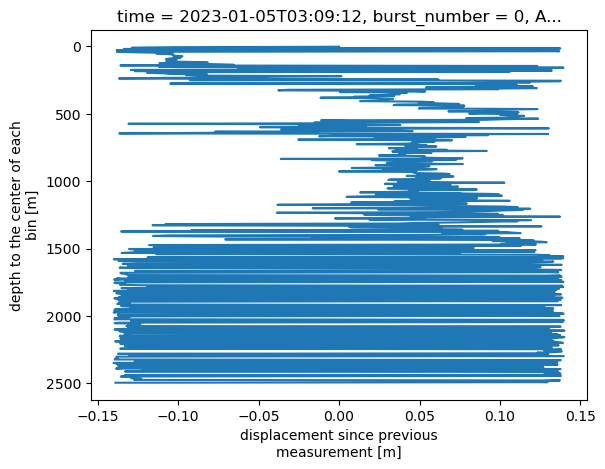

In [ ]:
displacement_binned(p1_stacked, p2_stacked).displacement.plot(y = 'bin_depth', yincrease=False)

## notes from doing the fft in numpy while writing ApRES data page:

fd = xa.load.from_dats(max_range=2500)
root_directory = 'gs://ldeo-glaciology/apres/thwaites/'
filenames = fd.list_files(directory = root_directory, remote_load=True)
len(filenames)

directory = os.path.dirname(filenames[20])
ds = fd.load_all(directory = directory, remote_load=True, file_numbers_to_process=[0])
ds

chirp = ds.chirp.squeeze()    # .squeeze() removes the singleton dimensions


def rdi(x):
    """round down to the nearest integer and return an integer"""
    return int(np.floor(x))
def rdei(x):
    """round down to the nearest even integer and return an integerr"""
    return int(np.floor(x/2) * 2)

t = chirp.chirp_time.values
N = rdei(len(s_one_chirp))-2
s_one_chirp = s_one_chirp[:N]
t = t[:N]

s_windowed = s_one_chirp * np.blackman(N)

plt.plot(t, s_one_chirp, label = 'chirp')
plt.plot(t, s_windowed, label = 'windowed chirp')
plt.legend()
plt.title('Windowing the chirp');
pad_factor = 2
s_padded = np.pad(s_windowed, pad_width=int((N*pad_factor-N)/2))

plt.plot(s_padded)
plt.title('padded chirp')
len(s_padded)
s_padded_rolled = np.roll(s_padded, shift = int(N*pad_factor/2))
plt.plot(s_padded_rolled)
plt.title('padded and rolled chirp');
Nt = rdei(len(s_one_chirp))
Nfft = rdi(Nt*pad_factor)
winchirp = np.multiply(s_one_chirp[0:Nt], np.blackman(Nt))

padchirp = np.zeros(Nfft)
padchirp[0:math.floor(Nt/2)] = winchirp[math.floor(Nt/2):]
padchirp[-math.floor(Nt/2):] = winchirp[0:math.floor(Nt/2)]
all(s_padded_rolled == padchirp)
def fft(s):
    no_of_samples = len(s)
    S = np.fft.fft(s, axis=0)/no_of_samples         
    indexes      = np.arange(no_of_samples) 
    frequencies  = indexes * sampling_frequency/no_of_samples
    return S, frequencies

def range(frequencies):
    return c * frequencies / (2*np.sqrt(ep)*K)
S, frequencies = fft(s_padded_rolled)
r = range(frequencies)
frequencies
profile_padded = np.fft.fft(s_padded_rolled)/Nfft * np.sqrt(2*pad_factor) 
bin2m1 = c/(2*pad_factor*np.sqrt(ep)*K)
r_padded1 = np.arange(Nfft) * bin2m1

profile_padded = np.fft.fft(s_padded_rolled)/Nfft * np.sqrt(2*pad_factor) 
bin2m2 = c/(2*np.sqrt(ep)*K) * sampling_frequency/Nfft
r_padded2 = np.arange(Nfft) * bin2m2
profile_padded = np.fft.fft(s_padded_rolled)/Nfft * np.sqrt(2*pad_factor) 
#profile_padded = profile_padded[0:math.floor(Nfft/2)-1]
bin2m3 = c/(2*np.sqrt(ep)*K) / Nfft / dt
r_padded3 = np.arange(Nfft) * bin2m3
sampling_frequency/Nfft
np.allclose(bin2m1, bin2m2)
np.allclose(r, r_padded3)